In [7]:
#*****************************************************************************
#Read the data, calculate basic statistics and plot the data sets
#*****************************************************************************


import numpy as np
import pandas as pd
import math #Used for Pi and log()
import sympy as sym
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import ones,vstack


path = '/Users/kevindeangeli/Desktop/Fall2019/COSC522/Project2/Dataset_PimaTr.txt'
training_data = pd.read_csv(path, delim_whitespace = 1, header=None)
training_data[training_data.shape[1]-1] = training_data[training_data.shape[1]-1].map({'Yes': 1, 'No': 0})

#training_data.columns=['x1', 'x2', 'y']
path2 =  '/Users/kevindeangeli/Desktop/Fall2019/COSC522/Project2/Dataset_PimaTest.txt'
test_data = pd.read_csv(path2, delim_whitespace = 1, header=None)
test_data[test_data.shape[1]-1] = test_data[test_data.shape[1]-1].map({'Yes': 1, 'No': 0})
#test_data.columns=['x1', 'x2', 'y']

meanArr=np.mean(training_data, axis=0)
varArr = np.std(training_data, axis=0)


nX=training_data[:]
nX_test = test_data[:]
for i in range(training_data.shape[1]-1):
    nX.loc[:,i] = (training_data.loc[:,i] - meanArr[i]) / varArr[i]
    
    
for i in range(test_data.shape[1]-1):
    nX_test.loc[:,i] = (test_data.loc[:,i] - meanArr[i]) / varArr[i]



y1Values = nX[nX[nX.shape[1]-1]==1]
y0Values = nX[nX[nX.shape[1]-1]==0]
y0Values=y0Values.drop(y0Values.columns[y0Values.shape[1]-1], axis=1)
y1Values=y1Values.drop(y1Values.columns[y1Values.shape[1]-1], axis=1)
    

y0meanArr = np.mean(y0Values, axis=0)
y1meanArr = np.mean(y1Values, axis=0)

y0Cov = y0Values.cov()
y1Cov= y1Values.cov()

y0Var = y0Values.var()
y1Var = y1Values.var()

y0Std = y0Values.std()
y1Std = y1Values.std()

meanArr = np.mean(nX, axis=0)
varArr = np.std(nX, axis=0)

In [8]:
def ConfusionMatrixWithPriors(testData,w,g0,g1):
    #Let class 0 = N; Class 1 = P;
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for index,row in testData.iterrows():
        x1= row[0:testData.shape[1]-1]
        g0_out = g0(x1,w)
        g1_out = g1(x1,w)
        if g0_out>=g1_out:
            guessLabel=0
        else:
            guessLabel=1
        rightLabel=row[test_data.shape[1]-1]
        if guessLabel==rightLabel:
            if rightLabel == 1:
                TP+=1
            else:
                TN+=1
        else:
            if rightLabel==1:
                FN+=1
            else:
                FP+=1
    #print(TP)
    totalRowsInData = test_data.shape[0]
    confusion_matrix = [['TP', TP], ["TN", TN], ['FP', FP], ['FN', FN],['Accuracy', (TN+TP)/totalRowsInData]]
    return confusion_matrix

In [9]:
#*******************************************************************************************
#Case I
#Testing the performance of the Case I Classifier:
#*******************************************************************************************
simgaY0 = (np.average(y0Std)+np.average(y1Std))/2

mewY0 = y0meanArr
mewY1 = y1meanArr

def g0(x, w):
    V= x
    return (((-1/(2*simgaY0)) * (np.dot(V,np.transpose(V)) \
    -2*np.dot(mewY0,np.transpose(V))+ np.dot(mewY0,np.transpose(mewY0))))+math.log(w)).item()

def g1(x, w):
    V= x
    return (((-1/(2*simgaY0)) * (np.dot(V,np.transpose(V)) \
    -2*np.dot(mewY1,np.transpose(V))+ np.dot(mewY1,np.transpose(mewY1))))+math.log(1-w)).item()


ConfusionMatrixWithPriors(nX_test,.66,g0,g1)


[['TP', 70],
 ['TN', 183],
 ['FP', 40],
 ['FN', 39],
 ['Accuracy', 0.7620481927710844]]

In [10]:
#*******************************************************************************************
#Case II
#Discriminat Function 
#Evaluating the acuracy.
#*******************************************************************************************
Ex = np.zeros((y1Values.shape[1],y1Values.shape[1]))

for i in range(y1Values.shape[1]):
    Ex[i][i] = (y0Std[i]+y1Std[i])/2
    

#E0E1Average1= np.average(y0Std)
#E0E1Average2= np.average(y1Std)

#Ex = np.array([(E0E1Average1,0), (0,E0E1Average2)])
Ex_inv = np.linalg.inv(Ex)
#print(type(Ex))

u0 = y0meanArr
u1 = y1meanArr

def g0(X, w):
    LHS1= np.dot(np.dot(Ex_inv,u0),X)
    LHS2= -.5 * np.dot(np.dot(u0,Ex_inv),u0)
    LHS3= math.log(w)
    LHS = LHS1 + LHS2 + LHS3
    return LHS

def g1(X, w):
    RHS1= np.dot(np.dot(Ex_inv,u1),X)
    RHS2= -.5 * np.dot(np.dot(u1,Ex_inv),u1)
    RHS3= math.log(1-w)
    RHS = RHS1 + RHS2 + RHS3
    return RHS


ConfusionMatrixWithPriors(nX_test,.66,g0,g1)

[['TP', 69],
 ['TN', 183],
 ['FP', 40],
 ['FN', 40],
 ['Accuracy', 0.7590361445783133]]

In [86]:
#*******************************************************************************************
#Case III
#Evaluating the classifiers:
#*******************************************************************************************

E0= y0Cov
E1 = y1Cov
E0_inv = np.linalg.inv(E0)
E1_inv = np.linalg.inv(E1)
u0 = y0meanArr
u1 = y1meanArr

def g0(X, w):
    LHS1A= -.5*E0_inv
    LHS1 = np.dot(np.dot(np.transpose(X),LHS1A),X)
    LHS2 = np.dot(np.transpose(np.dot(E0_inv,u0)),X)
    LHS3A= np.dot(np.dot(np.transpose(u0),E0_inv),u0)
    LHS3B= np.log(np.linalg.det(E0))
    LHS3 = -.5*(LHS3A+LHS3B)
    LHS = LHS1 + LHS2 + LHS3 + math.log(w)
    return LHS

def g1(X, w):
    RHS1A= -.5*E1_inv
    RHS1 = np.dot(np.dot(np.transpose(X),RHS1A),X)
    RHS2 = np.dot(np.transpose(np.dot(E1_inv,u1)),X)
    RHS3A= np.dot(np.dot(np.transpose(u1),E1_inv),u1)
    RHS3B= np.log(np.linalg.det(E1))
    RHS3 = -.5*(RHS3A+RHS3B)
    RHS = RHS1 + RHS2 + RHS3 + math.log(1-w)
    return RHS

ConfusionMatrixWithPriors(test_data,.5,g0,g1)

[['TP', 67],
 ['TN', 179],
 ['FP', 44],
 ['FN', 42],
 ['Accuracy', 0.7409638554216867]]

In [ ]:




y0x1Mean = y0Values.loc[:,"x1"].mean()
y0x2Mean = y0Values.loc[:,"x2"].mean()
y1x1Mean = y1Values.loc[:,"x1"].mean()
y1x2Mean = y1Values.loc[:,"x2"].mean()

y0x0=y0Values['x1'].tolist()
yox1=y0Values['x2'].tolist()
y0Cov=np.cov(np.array([y0x0,yox1]))
y1x0=y1Values['x1'].tolist()
y1x1=y1Values['x2'].tolist()
y1Cov=np.cov(np.array([y1x0,y1x1]))

y0X1Std = y0Cov[0,0]
y0X2Std = y0Cov[1,1]
y1X1Std = y1Cov[0,0]
y1X2Std = y1Cov[1,1]

def plotData():
    plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
    p1= plt.scatter(y0Values[['x1']], y0Values[['x2']], color='red', marker= 'x')
    p2=plt.scatter(y1Values[['x1']], y1Values[['x2']], color='green', marker= 'o')
    plt.xlim(-1.5,1.5)
    plt.ylim(-0.25,1.25)
    #plt.title("Data set from the Pattern Classification by Richard O. Duda")
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend((p1,p2),('Class 0','Class 1'))
    
def plotTestData():
    plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
    y1Values = test_data[test_data['y']==1] 
    y0Values = test_data[test_data['y']==0]
    p1= plt.scatter(y0Values[['x1']], y0Values[['x2']], color='red', marker= 'x')
    p2=plt.scatter(y1Values[['x1']], y1Values[['x2']], color='green', marker= 'o')
    plt.xlim(-1.5,1.5)
    plt.ylim(-0.25,1.25)
    #plt.title("Data set from the Pattern Classification by Richard O. Duda")
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend((p1,p2),('Class 0','Class 1'))
    
    
def classifyAndEvaluate(testData,w):
    right=0
    wrong=0
    for index,row in testData.iterrows():
        x1=row['x1']
        x2=row['x2']
        g0_out = g0(x1,x2,w)
        g1_out = g1(x1,x2,w)
        if g0_out>=g1_out:
            guessLabel=0
        else:
            guessLabel=1
        if guessLabel==row['y']:
            right= right+1
        else:
            wrong=wrong+1
    return right/test_data.shape[0]

def EvaluatePriorProbs(Ws,test_data):
    accuracyArray =[]
    for i in range(len(Ws)):
        w=Ws[i]
        #print("w: ", w)
        accuracy = classifyAndEvaluate(test_data,w)
        accuracyArray.append(accuracy)
    accuracyArray = np.array(accuracyArray)
    return accuracyArray

def plotAccuracyCurve(Ws,ys,figureName):
    fig, ax = plt.subplots(figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
    ax.plot(Ws, ys)
    ax.set(xlabel='Prior Probabbility (W)', ylabel='Accuracy',
    title=' ')
    #title='Finding the best accuracy')
    ax.grid()
    #plt.show()
    print("Maximun accuracy is provided is obtained when W= ",Ws[np.argmax(accuracy_array)])
    print("That corresponds to an accuracy of: ", np.amax(accuracy_array))
    print(" ")
    #plt.savefig(figureName)


Ws = np.arange(0.1, 1.0, 0.01)  #Can't start at 0 because log(0) = infinity -- These are Prior Probs.

mewY0 = np.array([[y0x1Mean,y0x2Mean]])
mewY1 = np.array([[y1x1Mean,y1x2Mean]])
plotData()
#plt.savefig('dataset.png')
plotTestData()
#plt.savefig('TestData.png')



In [9]:
#*******************************************************************************************
#This script prints the Recall (True Positive Rate (TPR)) and the True Negative Rate (TNR)
#It calculates the values for all the different prior probabilities and graph them together. 
#*******************************************************************************************



def ConfusionMatrixWithPriors(testData,w,g0,g1):
    #Let class 0 = N; Class 1 = P;
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for index,row in testData.iterrows():
        x1=row['x1']
        x2=row['x2']
        g0_out = g0(x1,x2,w)
        g1_out = g1(x1,x2,w)
        if g0_out>=g1_out:
            guessLabel=0
        else:
            guessLabel=1
        rightLabel=row['y']
        if guessLabel==rightLabel:
            if rightLabel == 1:
                TP+=1
            else:
                TN+=1
        else:
            if rightLabel==1:
                FN+=1
            else:
                FP+=1
    #print(TP)
    totalRowsInData = test_data.shape[0]
    confusion_matrix = [['TPR', TP/(TP+FN)], ["TNE", TN/(TN+FP)], ['FP', FP/totalRowsInData], ['FN', FN/totalRowsInData]]
    return confusion_matrix

def EvaluatePriorProbsConfusionMatrix(Ws,test_data,g0,g1):
    TPR_array =[]
    TNE_array =[]
    FP_array =[]
    FN_array =[]
    for i in range(len(Ws)):
        w=Ws[i]
        confusion_matrix = ConfusionMatrixWithPriors(test_data,w,g0,g1)
        TPR_array.append(confusion_matrix[0][1])
        TNE_array.append(confusion_matrix[1][1])
        FP_array.append(confusion_matrix[2][1])
        FN_array.append(confusion_matrix[3][1])
    plotRecallCurves(Ws,TPR_array,TNE_array)


def plotRecallCurves(Ws,TPR_array,TNE_array):
    fig, ax = plt.subplots(figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
    plt.plot(Ws,TPR_array, label= 'TPR (Class 1)')
    plt.plot(Ws,TNE_array, label= 'TNR (Class 0)' )
    ax.set(xlabel='Prior Probabbility (W)', ylabel='True Positive Rate (TPR) & True Negative Rate (TNR)',
    title=' ')
    plt.legend()
    ax.grid()
    print(" ")
    #plt.savefig('RecallCurve')


In [10]:
#*******************************************************************************************
#Declare two new functions to plot the missclassified points 
#together with the correctly classified data points. 
#*******************************************************************************************

def classifyAndEvaluateWithWrongDisplay(testData,w,g0,g1):
    right=0
    wrong=0
    wrongIndexes = []
    for index,row in testData.iterrows():
        x1=row['x1']
        x2=row['x2']
        g0_out = g0(x1,x2,w)
        g1_out = g1(x1,x2,w)
        if g0_out>=g1_out:
            guessLabel=0
        else:
            guessLabel=1
        if guessLabel==row['y']:
            right= right+1
        else:
            wrong=wrong+1
            wrongIndexes.append(index)
            
    WrongIndexTable=test_data.iloc[wrongIndexes]
    test_dataMinusWrongs = test_data.drop(wrongIndexes)
    plotWrongDataPoints(test_dataMinusWrongs,WrongIndexTable)
    #return wrongIndexes #Returns a list of indexes of misclassified points

def plotWrongDataPoints(test_data, wrongPoints):
    plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
    p1= plt.scatter(wrongPoints[['x1']], wrongPoints[['x2']], color='red', marker= 'x')
    p2=plt.scatter(test_data[['x1']], test_data[['x2']], color='yellow', marker= 'o')
    plt.xlim(-1.5,1.5)
    plt.ylim(-0.25,1.25)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend((p1,p2),('Misclassification','Correctly Classified'))
    plt.savefig('Miscclassification.png')

#classifyAndEvaluateWithWrongDisplay(test_data,.5,g0,g1)

# Case I : $\Sigma_{i} = \sigma^2 $


## $ g_i (x) =  - \frac{1}{2\sigma^2}[\textbf{x}^t \textbf{x}- 2\mu_{i}^t \textbf{x} + \mu_{i}^t \mu_{i}] + ln P(\omega_i) $      

Page 56 of pdf in Pattern recognition 



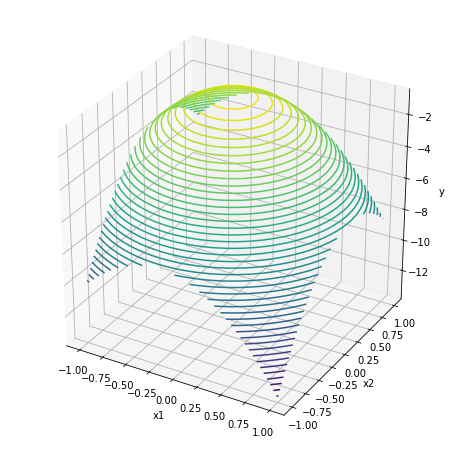

In [6]:
#*******************************************************************************************
#Case I
#Here is just a plot of g_0 just to see how it looks
#*******************************************************************************************

simgaY0=(y0X1Std + y0X2Std + y1X2Std+ y1X1Std)/4
mewY0 = np.array([[y0x1Mean,y0x2Mean]])
def f(x, y):
    V= np.array([[x,y]])
    w=.5
    return  (((-1/(2*simgaY0)) * (np.dot(V,np.transpose(V)) \
    -2*np.dot(mewY0,np.transpose(V))+ np.dot(mewY0,np.transpose(mewY0))))+math.log(w)).item()

x = np.linspace(-1, 1, 30)
y = np.linspace(-1, 1, 30)

X, Y = np.meshgrid(x, y)

Z = np.vectorize(f)
#Z = f(X, Y)
#print(Z)
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.contour3D(X, Y, Z(X,Y),50)
plt.savefig('discriminant.png')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y');

Maximun accuracy is provided is obtained when W=  0.32999999999999985
That corresponds to an accuracy of:  0.735
 
With equal prior probability, accuracy:  0.713


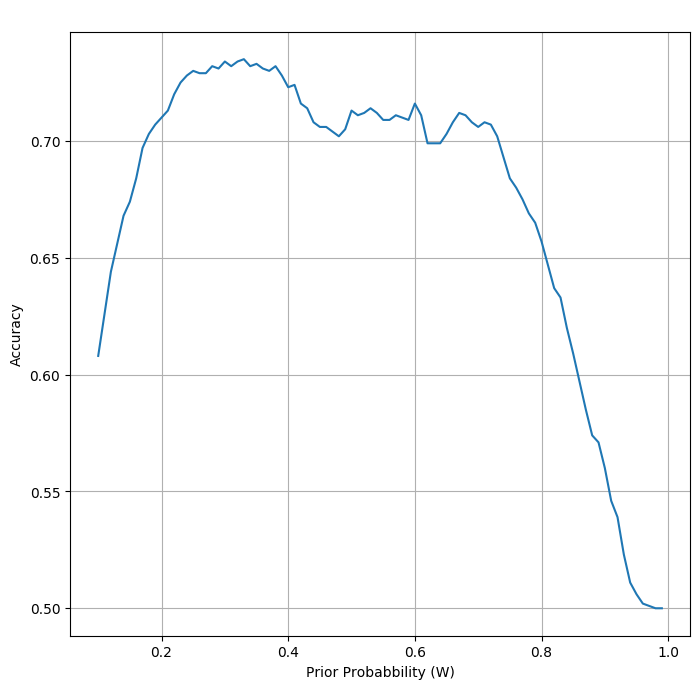

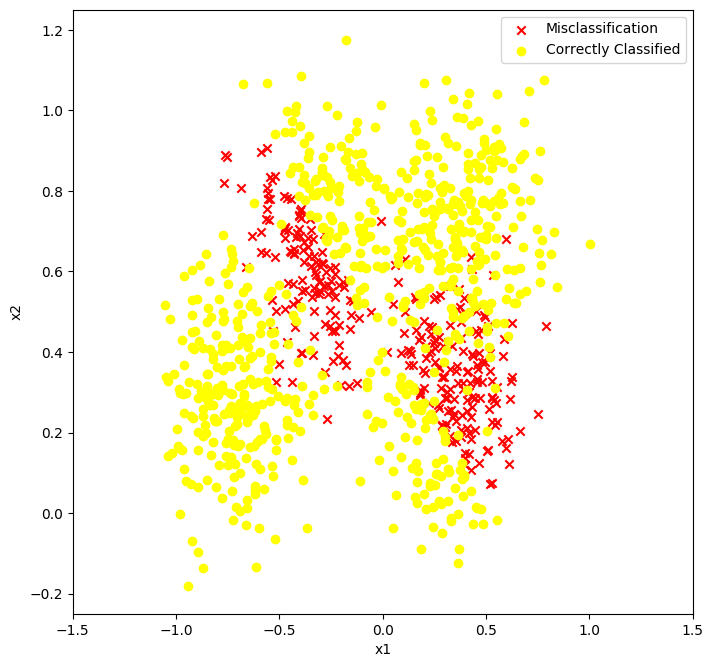

In [11]:
#*******************************************************************************************
#Case I
#Testing the performance of the Case I Classifier:
#*******************************************************************************************


simgaY0=(y0X1Std + y0X2Std + y1X2Std+ y1X1Std)/4  ## This should be arbitrary so I got the total avrage.
mewY0 = np.array([[y0x1Mean,y0x2Mean]])
mewY1 = np.array([[y1x1Mean,y1x2Mean]])

def g0(x, y, w):
    V= np.array([[x,y]])
    return (((-1/(2*simgaY0)) * (np.dot(V,np.transpose(V)) \
    -2*np.dot(mewY0,np.transpose(V))+ np.dot(mewY0,np.transpose(mewY0))))+math.log(w)).item()

def g1(x, y,w):
    V= np.array([[x,y]])
    return (((-1/(2*simgaY0)) * (np.dot(V,np.transpose(V)) \
    -2*np.dot(mewY1,np.transpose(V))+ np.dot(mewY1,np.transpose(mewY1))))+math.log(1-w)).item()

accuracy_array=EvaluatePriorProbs(Ws,test_data)

plotAccuracyCurve(Ws,accuracy_array,'CaseIAccuracy.png')

print("With equal prior probability, accuracy: ",classifyAndEvaluate(test_data,.5) )

classifyAndEvaluateWithWrongDisplay(test_data,.5,g0,g1)

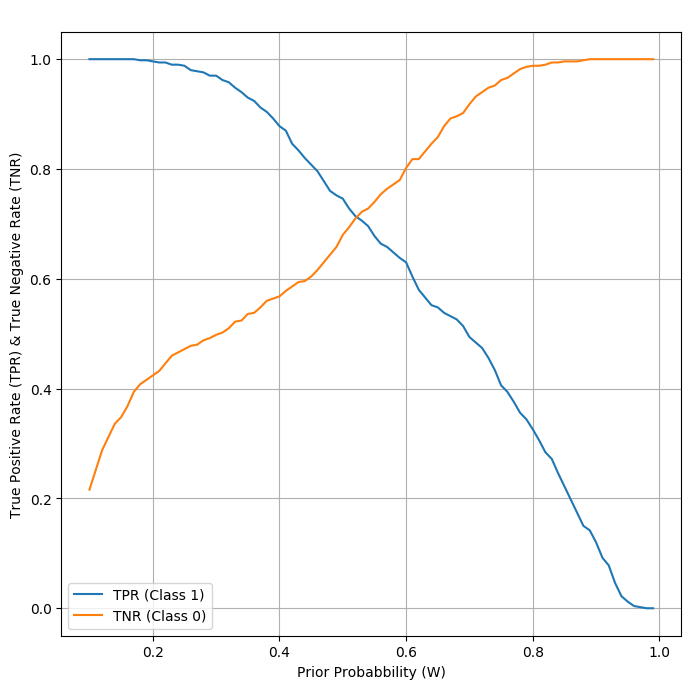

In [74]:
#*******************************************************************************************
#Plot the True Positive Rate/True Negative Rate for Case I
#*******************************************************************************************
accuracy_array=EvaluatePriorProbsConfusionMatrix(Ws,test_data,g0,g1)
plt.savefig('CaseI')

In [6]:
#*******************************************************************************************
#Case I
#In order to find the decision boundary, I used equation 56 (page 21) and the fact that:
#"This equation definesa hyperplane through the point x0 and 
#orthogonal to the vector w" Where w = u0-u1 (difference of means)
#*******************************************************************************************

u1 = np.array([-0.22147023711999997, 0.32575494064000005])
u2 = np.array([0.07595431392, 0.6829689131999999])
x1 = sym.Symbol('x1')
w = u1-u2
x0 = (u1+u2)/2
a= w*x1
a2=a-x0

a3=a2*w
eq= np.sum(a3)

sol= sym.solve(eq,x1)
sol2 = sol[0]
point2=w*sol2

print("The line passes through these two points: ")
print(point2)
print(x0)
print("\n")

print("Therefore, the equation of the line is :  y= -0.8326x+0.4438")

The line passes through these two points: 
[0.218219793016238 0.262087170954720]
[-0.07275796  0.50436193]


Therefore, the equation of the line is :  y= -0.8326x+0.4438


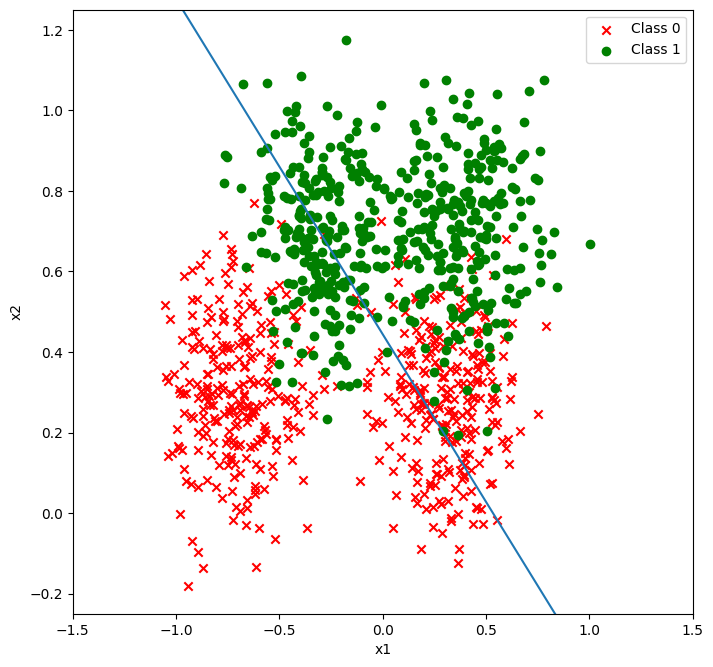

In [7]:
#*******************************************************************************************
#Case I
#Plotting Decision Boundary 
#*******************************************************************************************

def caseIdecisionRule():
    x= np.arange(-1.5,2,.1)
    y=[]
    for i in x:
        ii=-0.8326*i+0.4438
        y.append(ii)
    plt.plot(x,y)
    plt.savefig('CaseIDecisionBoundary.png')

#plotData()
#caseIdecisionRule()

plotTestData()
caseIdecisionRule()


# Case II : $\Sigma_{i} = \Sigma $ 


## $ g_i (x) =  (\Sigma^{-1}\mu_i)^t\textbf{x} - \frac{1}{2} \mu_i^t  \Sigma^{-1}\mu_i + ln P(\omega_i) $            


Page 59 of pdf in Pattern recognition 





<class 'numpy.ndarray'>
Maximun accuracy is provided is obtained when W=  0.44999999999999984
That corresponds to an accuracy of:  0.811
 
With Equal Prior Probability, accuracy:  0.8


NameError: name 'classifyAndEvaluateWithWrongDisplay' is not defined

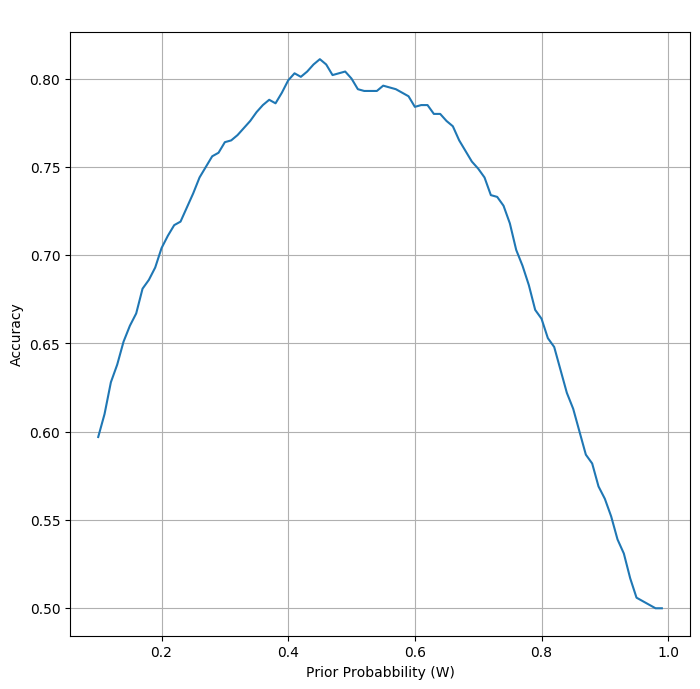

In [4]:
#*******************************************************************************************
#Case II
#Discriminat Function 
#Evaluating the acuracy.
#*******************************************************************************************
E0E1Average1= (y0X1Std+y0X2Std)/2
E0E1Average2= (y1X1Std+y1X2Std)/2
Ex = np.array([(E0E1Average1,0), (0,E0E1Average2)])
Ex_inv = np.linalg.inv(Ex)
#print(type(Ex))

u0 = np.array([-0.22147023711999997, 0.32575494064000005])
u1 = np.array([0.07595431392,0.6829689131999999])
def g0(x, y, w):
    X = np.array([x,y])
    LHS1= np.dot(np.dot(Ex_inv,u0),X)
    LHS2= -.5 * np.dot(np.dot(u0,Ex_inv),u0)
    LHS3= math.log(w)
    LHS = LHS1 + LHS2 + LHS3
    return LHS

def g1(x, y, w):
    X = np.array([x,y])
    RHS1= np.dot(np.dot(Ex_inv,u1),X)
    RHS2= -.5 * np.dot(np.dot(u1,Ex_inv),u1)
    RHS3= math.log(1-w)
    RHS = RHS1 + RHS2 + RHS3
    return RHS



accuracy_array=EvaluatePriorProbs(Ws,test_data)
plotAccuracyCurve(Ws,accuracy_array,'CaseIIAcuracy.png')

print("With Equal Prior Probability, accuracy: ", classifyAndEvaluate(test_data,.5))
classifyAndEvaluateWithWrongDisplay(test_data,.5,g0,g1)

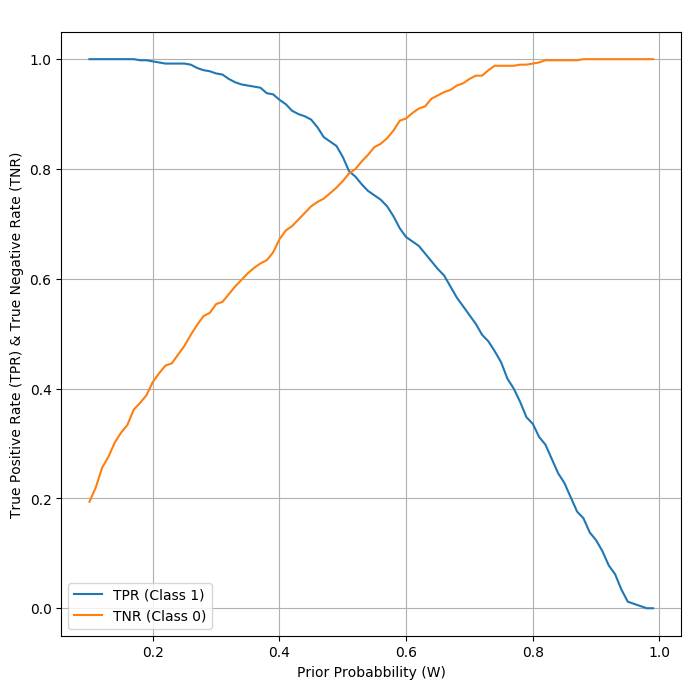

In [76]:
#*******************************************************************************************
#True Postive Rate/ True Negative Rate for Case II
#*******************************************************************************************

accuracy_array=EvaluatePriorProbsConfusionMatrix(Ws,test_data,g0,g1)
plt.savefig('CaseII')

In [11]:
#*******************************************************************************************
#Case II
#Finding Decision Boundary:
#*******************************************************************************************


E0E1Average1= (y0X1Std+y0X2Std)/2
E0E1Average2= (y1X1Std+y1X2Std)/2
Ex = np.array([(E0E1Average1,0), (0,E0E1Average2)])
Ex_inv= np.linalg.inv(Ex)

u0 = np.array([-0.22147023711999997, 0.32575494064000005])
u1 = np.array([0.07595431392,0.6829689131999999])

x1 = sym.Symbol('x1')
x2 = sym.Symbol('x2')
X = np.array([x1,x2])

LHS1= np.dot(np.dot(Ex_inv,u0),X)
LHS2= -.5 * np.dot(np.dot(u0,Ex_inv),u0)
LHS = LHS1 + LHS2

RHS1= np.dot(np.dot(Ex_inv,u1),X)
RHS2= -.5 * np.dot(np.dot(u1,Ex_inv),u1)
RHS = RHS1 + RHS2

eq = LHS + (-1*RHS)

sol= sym.solve(eq,x2, set=True)
print("Rule 2 - Classification boundary: ", sol)


Rule 2 - Classification boundary:  ([x2], {(0.467636629718861 - 0.504759841995623*x1,)})


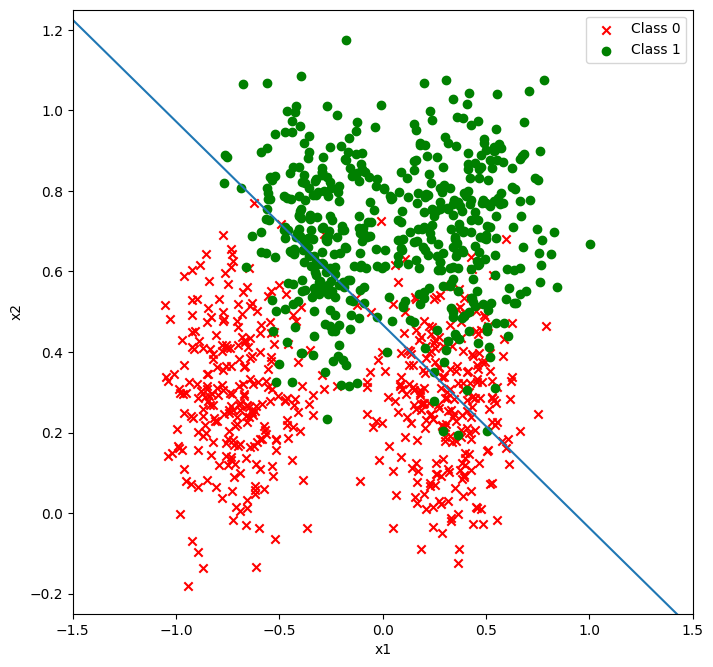

In [7]:
#*******************************************************************************************
#Case II
#Plotting Decision Boundary:
#*******************************************************************************************



def caseIIdecisionRule():
    x= np.arange(-1.5,2,.1)
    y=[]
    for i in x:
        ii=0.467636629718861 - 0.504759841995623*i
        y.append(ii)
    plt.plot(x,y)
    plt.savefig('CaseIIDecisionBoundary.png')
    
#plotData()
#caseIIdecisionRule()
plotTestData()
caseIIdecisionRule()



# Case III : $\Sigma_{i} = Arbitrary$



## $ g_i (x) = [\textbf{x}^t (-\frac{1}{2}\Sigma_{i}^{-1})\textbf{x} ] + [(\Sigma_{i}^{-1}\mu_{i})^t \textbf{x}]   -\frac{1}{2}[\mu_i^t \Sigma_{i}^{-1} \mu_{i}  + ln |\Sigma_{i}|]+ ln P(\omega_i)  $   


(Assuming equal prior probabilities)

Page 61 of pdf in Pattern recognition 


$  g_1 (x)= g_0 (x) $

Maximun accuracy is provided is obtained when W=  0.45999999999999985
That corresponds to an accuracy of:  0.9
 
With Equal Prior Probability, accuracy:  0.898


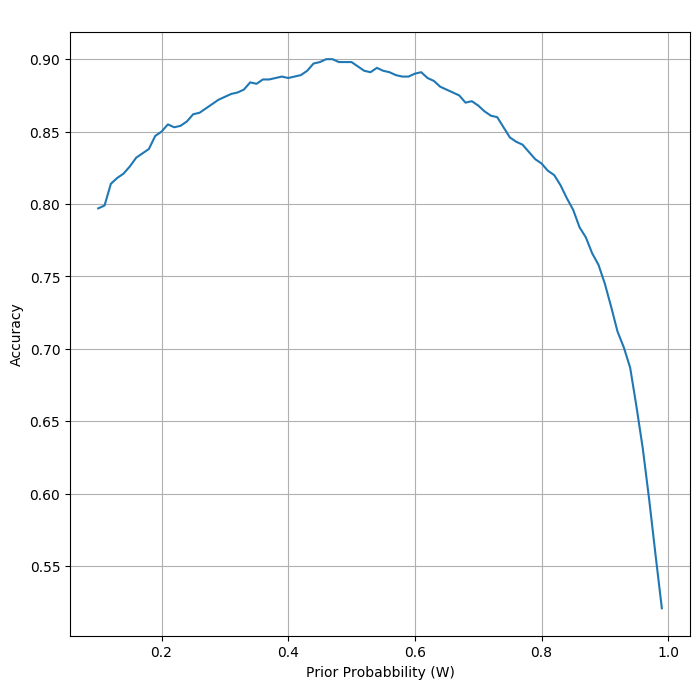

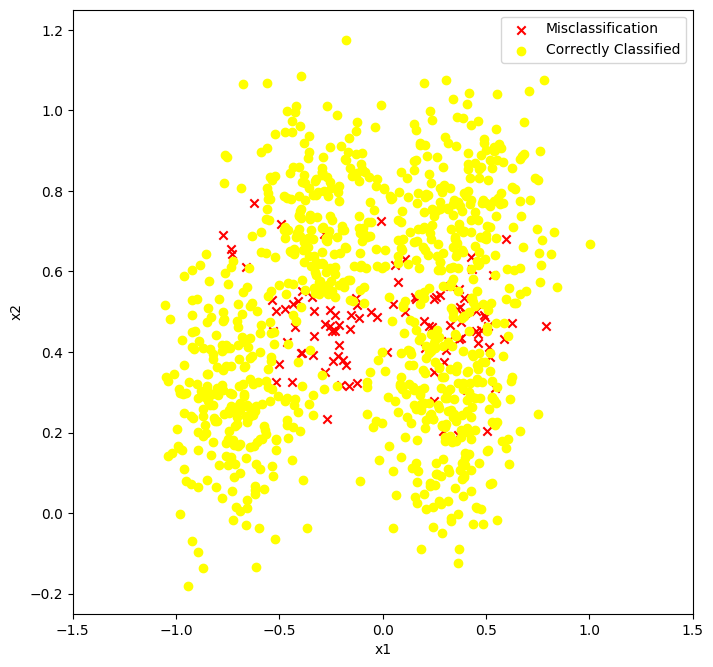

In [77]:
#*******************************************************************************************
#Case III
#Evaluating the classifiers:
#*******************************************************************************************


E0= y0Cov
E1 = y1Cov
E0_inv = np.linalg.inv(E0)
E1_inv = np.linalg.inv(E1)
u0 = np.array([y0x1Mean, y0x2Mean])
u1 = np.array([y1x1Mean,y1x2Mean])

def g0(x, y, w):
    X = np.array([x,y])
    LHS1A= -.5*E0_inv
    LHS1 = np.dot(np.dot(np.transpose(X),LHS1A),X)
    LHS2 = np.dot(np.transpose(np.dot(E0_inv,u0)),X)
    LHS3A= np.dot(np.dot(np.transpose(u0),E0_inv),u0)
    LHS3B= np.log(np.linalg.det(E0))
    LHS3 = -.5*(LHS3A+LHS3B)
    LHS = LHS1 + LHS2 + LHS3 + math.log(w)
    return LHS

def g1(x, y, w):
    X = np.array([x,y])
    RHS1A= -.5*E1_inv
    RHS1 = np.dot(np.dot(np.transpose(X),RHS1A),X)
    RHS2 = np.dot(np.transpose(np.dot(E1_inv,u1)),X)
    RHS3A= np.dot(np.dot(np.transpose(u1),E1_inv),u1)
    RHS3B= np.log(np.linalg.det(E1))
    RHS3 = -.5*(RHS3A+RHS3B)
    RHS = RHS1 + RHS2 + RHS3 + math.log(1-w)
    return RHS

accuracy_array=EvaluatePriorProbs(Ws,test_data)
plotAccuracyCurve(Ws,accuracy_array,'CaseIIIAccuracy.png')


print("With Equal Prior Probability, accuracy: ", classifyAndEvaluate(test_data,.5))
classifyAndEvaluateWithWrongDisplay(test_data,.5,g0,g1)

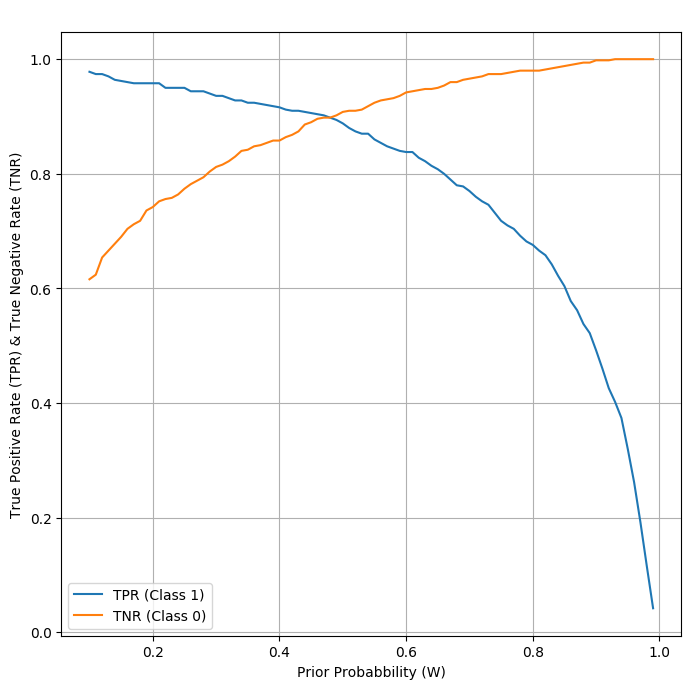

In [78]:
#*******************************************************************************************
#True Postive Rate/True Negative Rate for Case III
#*******************************************************************************************


accuracy_array=EvaluatePriorProbsConfusionMatrix(Ws,test_data,g0,g1)
plt.savefig('CaseIII')

In [8]:
#*******************************************************************************************
#Case 3
# Finding decision boundary:
#*******************************************************************************************


E0= y0Cov
E1 = y1Cov
E0_inv = np.linalg.inv(E0)
E1_inv = np.linalg.inv(E1)
u0 = np.array([y0x1Mean, y0x2Mean])
u1 = np.array([y1x1Mean,y1x2Mean])
x1 = sym.Symbol('x1')
x2 = sym.Symbol('x2')
X = np.array([x1,x2])

LHS1A= -.5*E0_inv
LHS1 = np.dot(np.dot(np.transpose(X),LHS1A),X)
LHS2 = np.dot(np.transpose(np.dot(E0_inv,u0)),X)
LHS3A= np.dot(np.dot(np.transpose(u0),E0_inv),u0)
LHS3B= np.log(np.linalg.det(E0))
LHS3 = -.5*(LHS3A+LHS3B)

LHS = LHS1 + LHS2 + LHS3

RHS1A= -.5*E1_inv
RHS1 = np.dot(np.dot(np.transpose(X),RHS1A),X)
RHS2 = np.dot(np.transpose(np.dot(E1_inv,u1)),X)
RHS3A= np.dot(np.dot(np.transpose(u1),E1_inv),u1)
RHS3B= np.log(np.linalg.det(E1))
RHS3 = -.5*(RHS3A+RHS3B)

RHS = RHS1 + RHS2 + RHS3

eq1 = LHS + (-1*RHS)
sol= sym.solve(eq1,x2)

print("Rule 3 - Classification boundary: ", sol[0])

Rule 3 - Classification boundary:  -0.641052306096729*x1 - 2.80817434975417e-16*sqrt(-1.52678246136875e+28*x1**2 - 1.96622605613547e+31*x1 + 3.28073472343665e+31) + 2.0905232940685


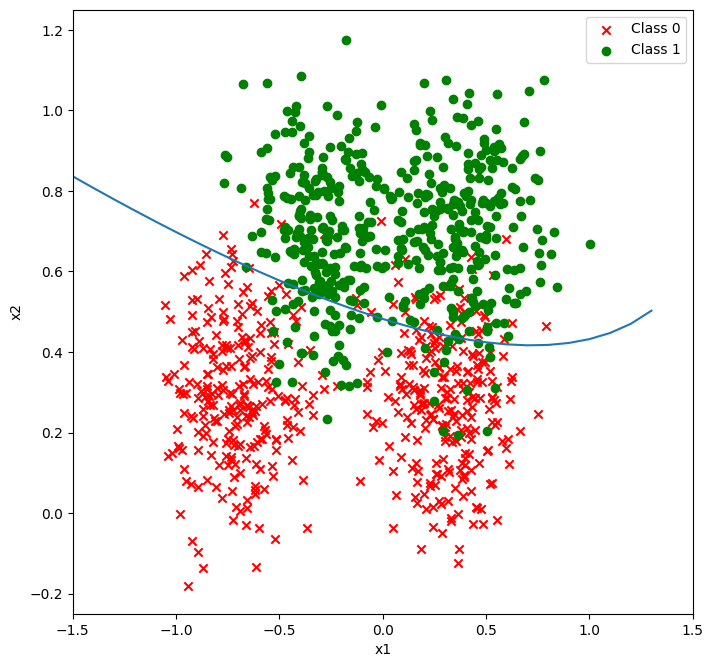

In [9]:
#Case III
#Ploting decision boundary:

def caseIIIdecisionRule():
    x= np.arange(-1.5,1.4,.1)
    y=[]
    for i in x:
        ii = sol[0].subs(x1,i)
        y.append(ii)
    plt.plot(x,y)
    plt.savefig('CaseIIIDecisionBoundary.png')

plotTestData()
caseIIIdecisionRule()



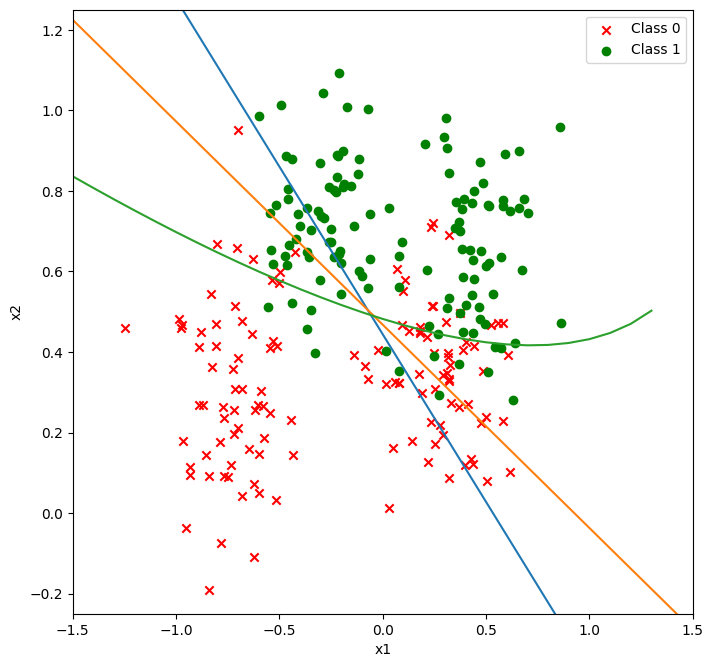

In [10]:
#*******************************************************************************************
#Plotting all decision boundaries together:
#*******************************************************************************************


plotData()

x= np.arange(-1.5,2,.1)
y=[]
for i in x:
    ii=-0.8326*i+0.4438
    y.append(ii)
plt.plot(x,y)

y=[]
for i in x:
    ii=0.467636629718861 - 0.504759841995623*i
    y.append(ii)
plt.plot(x,y)

x= np.arange(-1.5,1.4,.1)
y=[]
for i in x:
    ii = sol[0].subs(x1,i)
    y.append(ii)
plt.plot(x,y)
plt.savefig('AllCasesDecisionBoundary.png')


# Two modal gaussian

In [12]:

#*******************************************************************************************
#Define the two gaussian discriminants and calcualte accuracy. (Equal Prior probability)
#*******************************************************************************************


def g0(x, y, w):
    mu1 = np.array([-0.75,  0.2]);
    mu2 = np.array([0.3, 0.3]);
    S1  = np.array([[0.25, 0], [0, 0.3]]);
    S2  = np.array([[0.1, 0],  [0, 0.1]]);
    A1  = 0.8;
    A2  = 1 - A1;
    d=2
    S1_inv = np.linalg.inv(S1)
    S2_inv = np.linalg.inv(S2)
    X = np.array([x,y])
    
    
    p1a= (2*math.pi)**(d/2)
    p1b=A1/((np.linalg.det(S1))**(1/2)*p1a)
    p1c=np.exp((-1/2)*(np.dot(np.dot(np.transpose((X - mu1)),S1_inv),(X-mu1))))
    p1=p1b*p1c

    p2a= (2*math.pi)**(d/2)
    p2b=A2/((np.linalg.det(S2))**(1/2)*p2a)
    p2c=np.exp((-1/2)*(np.dot(np.dot(np.transpose((X - mu2)),S2_inv),(X-mu2))))
    p2=p2b*p2c
    
    return p2+p1

def g1(x, y, w):
    #mu1 = np.array([0.38, 0.70])
    #mu2 = np.array([-0.29, 0.69])
    mu1 = np.array([-0.31, 0.75])
    mu2 = np.array([0.48, 0.65])
    S1  = np.array([[0.03, 0], [0, 0.029]])
    S2  = np.array([[0.029, 0],  [0, 0.28]])
    A1  = 0.8;
    A2  = 1 - A1;
    d=2
    S1_inv = np.linalg.inv(S1)
    S2_inv = np.linalg.inv(S2)
    
    X = np.array([x,y])
    
    p1a= (2*math.pi)**(d/2)
    p1b=A1/((np.linalg.det(S1))**(1/2)*p1a)
    p1c=np.exp((-1/2)*(np.dot(np.dot(np.transpose((X - mu1)),S1_inv),(X-mu1))))
    p1=p1b*p1c

    p2a= (2*math.pi)**(d/2)
    p2b=A2/((np.linalg.det(S2))**(1/2)*p2a)
    p2c=np.exp((-1/2)*(np.dot(np.dot(np.transpose(X - mu2),S2_inv),(X-mu2))))
    p2=p2b*p2c
    
    return p2+p1

print("Two-Modal Gaussian, accuracy: ",classifyAndEvaluate(test_data,.5))

Two-Modal Gaussian, accuracy:  0.875


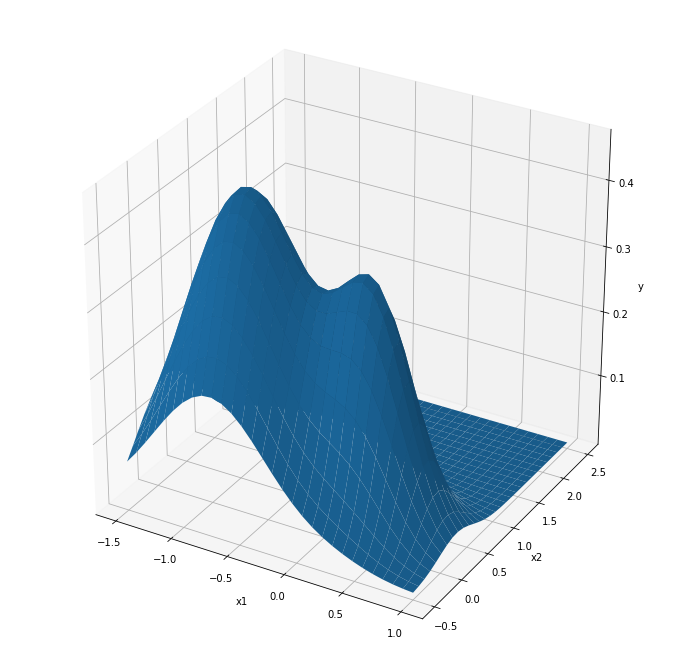

In [65]:
#*******************************************************************************************
#Prints the Gaussian figure in 3d (P1)
#*******************************************************************************************



fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(-1.5, 1, 30)
y = np.linspace(-.5, 2.5, 30)
X, Y = np.meshgrid(x, y)
Z = np.vectorize(g0)
Z2= np.vectorize(g1)

ax.plot_surface(X, Y, Z(X,Y,.5))


ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y');
plt.savefig('TwoModal0.png')


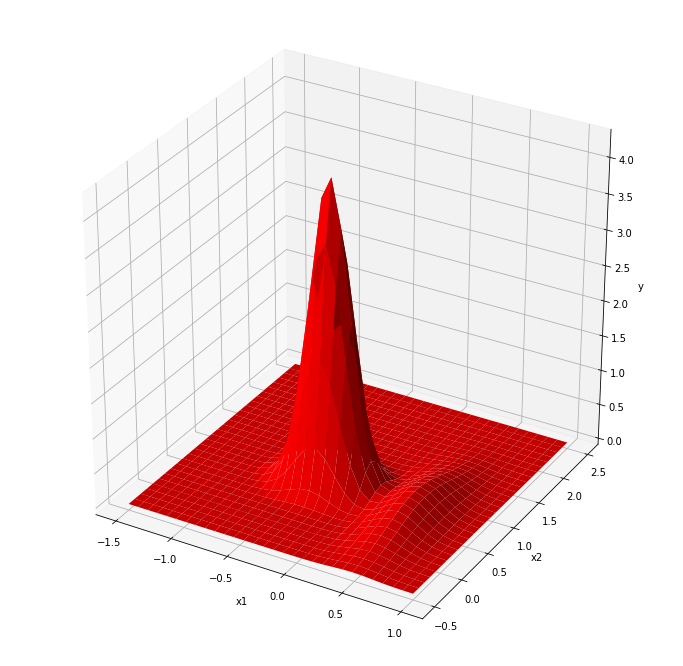

In [13]:
#*******************************************************************************************
#Prints the Gaussian figure in 3d (P2)
#*******************************************************************************************


fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(-1.5, 1, 30)
y = np.linspace(-.5, 2.5, 30)
X, Y = np.meshgrid(x, y)
Z = np.vectorize(g0)
Z2= np.vectorize(g1)

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y');

ax.plot_surface(X, Y, Z2(X,Y,.5), color='r')
#plt.savefig('TwoModal1.png')
